In [1]:
# Packages
libs = c('dplyr','magrittr','tidyr','purrr','stringr','data.table','lubridate','scales',
         'ggplot2','viridis','grid','gridExtra')
for (x in libs) {library(x, character.only = T, warn.conflicts = F)}

Loading required package: viridisLite



In [2]:
# Load datasets
clusters_info <- readRDS("../data/clusters_info.rds")
clusters_df <- readRDS("../data/clusters_df.rds")
key <- readRDS("../data/key.rds")
prnew <- readRDS("../results/prnew.rds")

In [3]:
# Establish reference date and values
t0 = as.Date("2020-01-01")
daystocalc = 14*3
first_onset_date <- clusters_info %>% pull(firstonset); names(first_onset_date) <- key
last_report_date <- clusters_info %>% pull(lastreport); names(last_report_date) <- key
last_report_day <- as.integer(last_report_date - t0); names(last_report_day) <- key
calc_overall_end_date <- last_report_date + daystocalc - 1; names(calc_overall_end_date) <- key
calc_overall_end_day <- as.integer(calc_overall_end_date - t0); names(calc_overall_end_day) <- key

In [4]:
# Choose parameters for figure 1
Re = c(0.5, 1.5, 3)
k_mu = c(0.11, 0.25, 0.58)
plot_pars <- c(Re[1], k_mu[2]) # Set Re and k to use for Figure

# Other plot necessities
cluster_labs <- c("Aichi gyms",
                  "Kyoto university parties",
                  "Hokkaido senior care facility",
                  "Hokkaido Cancer Center")
names(cluster_labs) <- key
title_letters <- c("A", "B", "C", "D") ; names(title_letters) <- key

In [5]:
# Plot settings
theme_set(theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                panel.background = element_blank(), axis.line = element_line(colour = "black")))
'%&%' = function(x,y) paste0(x,y)

# Bimonthly dates
bimonthly <- function(x) {
  x_range <- range(x, na.rm = TRUE)
  date_range <- c(
    floor_date(x_range[1], "month"),
    ceiling_date(x_range[2], "month"))
  monthly <- seq(as.Date(date_range[1]), as.Date(date_range[2]), by = "1 month")
  sort(c(monthly, monthly + days(14)))
}

bimonthly_labels <- function(x) paste0(day(bimonthly(x)), " ", month(ymd(bimonthly(x)), label=TRUE, abbr=FALSE))

In [6]:
case_plot = list()
prnew_plot = list()

data_type_order = c("Reported", "Imputed", "20% underascertainment", "50% underascertainment")

for (cl in key) {
    
epicurve_x_lims = c(first_onset_date[cl]-5, last_report_date[cl]+1)
prnew_x_lims = c(0, daystocalc)
last_case <- paste0("Last case: ", month(ymd(last_report_date[cl]), label=TRUE, abbr=FALSE), " ", day(last_report_date[cl]))
    
reported_df <- bind_rows(clusters_df %>% filter(cluster==cl) %>% count(report) %>% rename(date=1, ncases=2) %>% mutate(ncases = as.numeric(ncases), data_type = "report", plot_type = "report"), 
            clusters_df %>% filter(cluster==cl) %>% count(report) %>% mutate(ncases=cumsum(n), data_type = "cumsum", plot_type = "report") %>% dplyr::select(-2) %>% rename(date=1))
    
epicurve_df <- bind_rows(clusters_df %>% filter(cluster==cl & !is.na(onset)) %>% count(onset) %>% rename(date=1, onset=2) %>% mutate(onset = as.numeric(onset))  %>%
               right_join(clusters_df %>% filter(cluster==cl) %>% count(onset_imputed) %>% rename(date=1, onset_imputed=2), by="date") %>% replace_na(list(onset=0)) %>% 
               mutate(imputed = -(onset_imputed-onset)) %>% dplyr::select(-onset_imputed) %>% arrange(date) %>% pivot_longer(!date, names_to = "data_type", values_to = "ncases") %>% mutate(plot_type = "onset"),
               reported_df)
    
prnew_df <- prnew %>% filter(Re==plot_pars[1], k==plot_pars[2]) %>%
            filter(cluster==cl & Re==plot_pars[1] & k==plot_pars[2]) %>% dplyr::select(-day) %>% 
            mutate(data_type = factor(data_type, levels=data_type_order))

slice_5pct_q20 <- prnew_df %>% filter(data_type=="20% underascertainment" & median<0.05) %>% arrange(days_since_last_case) %>% slice(1L)
slice_5pct_q50 <- prnew_df %>% filter(data_type=="50% underascertainment" & median<0.05) %>% arrange(days_since_last_case) %>% slice(1L)

cumsum_df <- epicurve_df %>% filter(data_type=="cumsum") %>% complete(date = seq.Date(min(date), max(date), by="1 day")) %>% fill(data_type, ncases, plot_type)
cumsum_y_breaks = c(0,50,100)
prnew_x_breaks = pretty(prnew_df %>% dplyr::select(days_since_last_case) %>% pull(), 10)
    
case_plot[[cl]] <- ggplot(cumsum_df) + 
          geom_bar(aes(x=date, y=ncases, fill=data_type), stat="identity", width=1, fill="lightblue", show.legend=FALSE) +
          ggtitle("Cumulative cases") +
          annotate(geom="text", x=epicurve_x_lims[1]+2, y=95, label=last_case, hjust=0, size=3) +
          scale_x_date("Date of report", expand=c(0,0), breaks=bimonthly, labels=date_format("%b %e"), limits=epicurve_x_lims) +
          scale_y_continuous("Number of cases", breaks = cumsum_y_breaks, labels = cumsum_y_breaks, expand=c(0, 0), limits = c(min(cumsum_y_breaks), max(cumsum_y_breaks))) +
          theme_classic() +
          theme(title = element_text(size=10),
                axis.title = element_text(size=9), 
                plot.margin = unit(c(0,0,-0.3,0), "cm"))
    
prnew_plot[[cl]] <- ggplot(prnew_df) + 
          geom_hline(aes(yintercept=5), linetype = "dashed") +
          geom_line(aes(x=days_since_last_case, y=median*100, color=data_type)) +
          geom_ribbon(aes(x=days_since_last_case, ymin=lci*100, ymax=uci*100, fill=data_type), alpha=0.2) +
          geom_point(data=slice_5pct_q20, aes(x=days_since_last_case, y=median*100)) +
          geom_label(data=slice_5pct_q20, aes(x=days_since_last_case, y=median*100+2, label=paste0("Day\n", days_since_last_case)), vjust=0, size=3) +
    
          ggtitle(paste0(title_letters[cl], ". ", cluster_labs[cl])) +
#           annotate(geom="text", x=daystocalc*.98, y=27, 
#                    label=ifelse(nmissing_onset[cl]==1, paste0(nmissing_onset[cl], " missing onset"), paste0(nmissing_onset[cl], " missing onsets")), hjust=1, size=3.2) +
          scale_x_continuous("Days since last case reported", expand=c(0,0), breaks=prnew_x_breaks, labels=prnew_x_breaks, limits=prnew_x_lims) +
          scale_y_continuous("Probability of new cases, %", position = "left", expand=c(0,0), limits=c(0,100)) +
          scale_color_manual("", values=viridis(5)[c(1,2,4,5)]) +
          scale_fill_manual("", values=viridis(5)[c(1,2,4,5)]) +
          theme_classic() +
          theme(text = element_text(size=12),
                legend.position="bottom",
                legend.title = element_blank(),
                legend.text = element_text(size=11),
                legend.background = element_rect(colour = "transparent", fill = "transparent"),
                title = element_text(size=12), 
                plot.margin = unit(c(0.5,0.2,0.5,0), "cm"))
}

TableGrob (3 x 2) "arrange": 5 grobs
  z     cells    name              grob
1 1 (1-1,1-1) arrange    gtable[layout]
2 2 (1-1,2-2) arrange    gtable[layout]
3 3 (2-2,1-1) arrange    gtable[layout]
4 4 (2-2,2-2) arrange    gtable[layout]
5 5 (3-3,1-1) arrange gtable[guide-box]

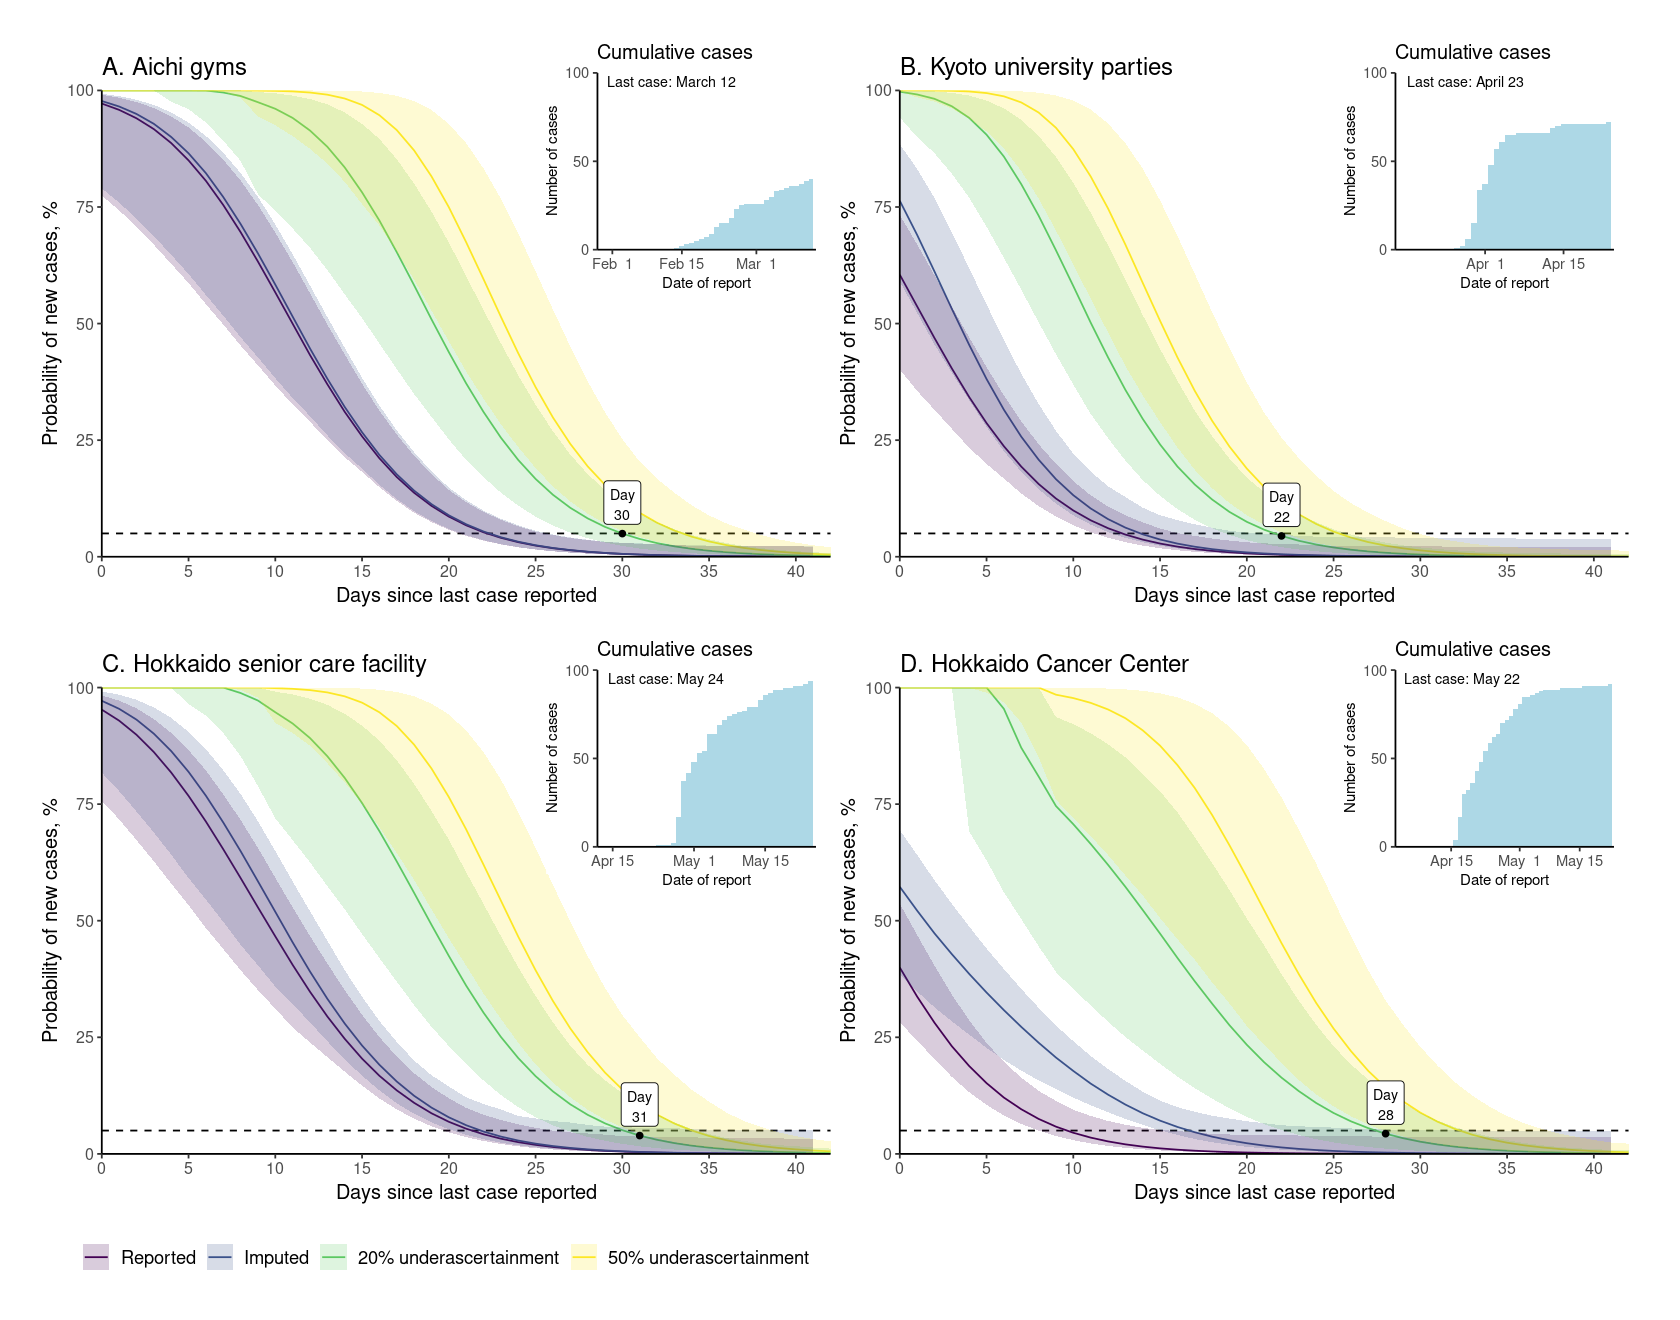

In [7]:
cs = c(14,11)
options(repr.plot.width=cs[1],repr.plot.height=cs[2])

#extract legend
#https://github.com/hadley/ggplot2/wiki/Share-a-legend-between-two-ggplot2-graphs
g_legend<-function(a.gplot) {
  tmp <- ggplot_gtable(ggplot_build(a.gplot))
  leg <- which(sapply(tmp$grobs, function(x) {x$name} ) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend) }

mylegend <-g_legend( prnew_plot[[1]] )

full_plot <- lapply(key, function(cl) { prnew_plot[[cl]] + theme(legend.position="none") + 
                                        annotation_custom(grob = ggplotGrob(case_plot[[cl]]), xmin=daystocalc*.61, xmax=daystocalc*.98, ymin=60, ymax=110) })
fig1 <- do.call("grid.arrange", c(full_plot, list(vp=viewport(width=0.95, height=0.95), mylegend, nrow=3, heights=c(10,10,1))))
fig1